# Labeling

In [1]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import random
import cv2
import json

In [2]:
data_root = "../../dataset/52_2/"

DOGU_root = os.path.join(data_root, 'DOGU')

In [3]:
sample_dir = os.path.join(DOGU_root, 'CP', 'a', 'cloudy', '220719', '17-19')

segmentation_dir = os.path.join(DOGU_root, 'CP', 'a', 'cloudy', '220719', '17-19', 'seg', 'segmentation')
mask_dir = os.path.join(DOGU_root, 'CP', 'a', 'cloudy', '220719', '17-19', 'seg', 'mask')

print(os.path.exists(segmentation_dir))
print(os.path.exists(mask_dir))

True
True


In [4]:
sample_fn = random.sample(os.listdir(segmentation_dir), 1)[0]
print(sample_fn)

20220719_175527_71.json


- segmentation 파일 읽기

In [5]:
with open(os.path.join(segmentation_dir, sample_fn), 'r') as f:
    sample_seg_data = json.load(f)

In [6]:
# keys
sample_seg_data.keys()

dict_keys(['data_key', 'objects', 'meta'])

In [7]:
# meta data
meta = sample_seg_data['meta']
meta

{'location': 'CP',
 'scenario': 'a',
 'weather': 'cloudy',
 'date_time': '220719_17-19',
 'size': {'width': 1920, 'height': 1080}}

In [8]:
height, width = meta['size']['height'], meta['size']['width']

In [9]:
# objects
objects = sample_seg_data['objects']

for obj in objects:
    print("keys: ", obj.keys())
    print('class: ', obj['class'])
    print('properties: ', obj['properties'])
    print('annotation: \n\t', obj['annotation'][0][0][:10], '...')
    break

keys:  dict_keys(['class', 'annotation', 'properties'])
class:  OUT_Road
properties:  {}
annotation: 
	 [{'x': 13, 'y': 734}, {'x': 12, 'y': 735}, {'x': 8, 'y': 735}, {'x': 7, 'y': 736}, {'x': 3, 'y': 736}, {'x': 2, 'y': 737}, {'x': 0, 'y': 737}, {'x': 0, 'y': 766}, {'x': 0, 'y': 764}, {'x': 1, 'y': 763}] ...


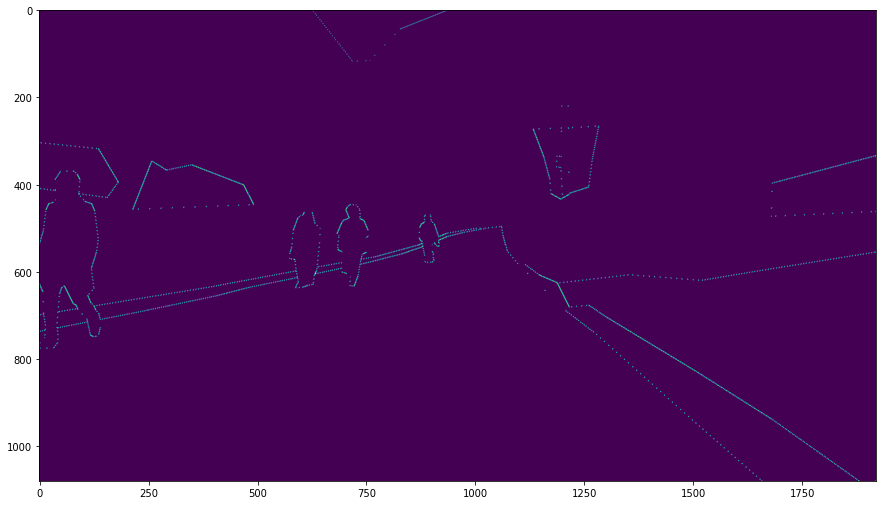

In [10]:
# annotation 시각화
segmentation_img = np.zeros((height, width), dtype=np.uint8)

for obj in objects:
    anno_pts = obj['annotation'][0][0]
    
    for pt in anno_pts:
        y, x = pt['y'], pt['x']
        segmentation_img[y, x] = 255     # 255는 아무 숫자나 바꿔도 됨. 확인 용도
        
# 이미지 출력
plt.figure(figsize=(15, 20))
plt.imshow(segmentation_img)
plt.show()

## segmenation file과 mask file 매칭

In [11]:
sample_fn

'20220719_175527_71.json'

In [12]:
sample_mask_file = "{}.png".format(os.path.splitext(sample_fn)[0])
sample_mask_file

'20220719_175527_71.png'

In [13]:
def read_mask_file(path, mode='None'):
    mask_data = cv2.imread(path, mode)
    mask_values = np.unique(mask_data)
    return mask_data, mask_values

Gray Scale values:  [  0  58 111 114 177 183 184 188]


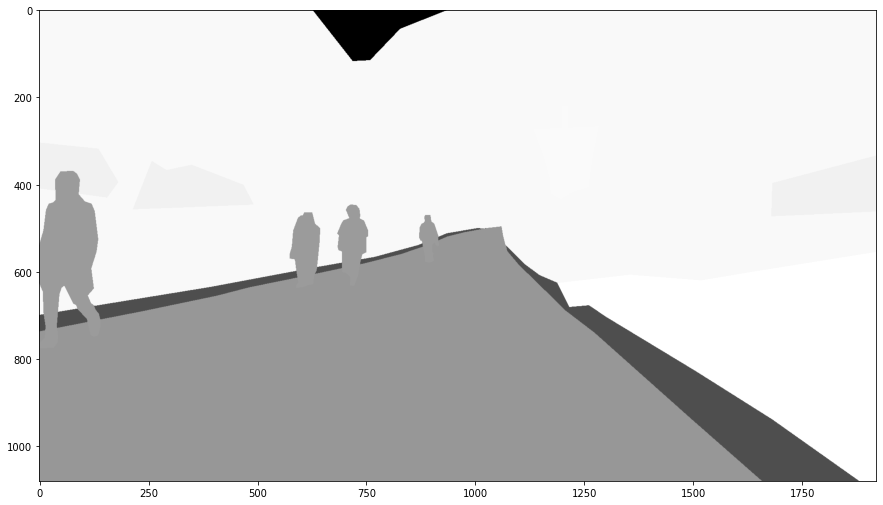

In [14]:
mask_data, mask_values = read_mask_file(os.path.join(mask_dir, sample_mask_file), cv2.IMREAD_GRAYSCALE)
print("Gray Scale values: ", mask_values)

# 이미지 출력
plt.figure(figsize=(15, 20))
plt.imshow(mask_data, cmap='gray')
plt.show()

- 매칭 하기

In [15]:
class_names = {
    'unlabled': 0
}

label_mask = np.zeros((height, width), dtype=np.uint8)

In [16]:
for obj in objects:
    _label_mask = np.zeros((height, width), dtype=int)
    class_ = obj['class']
    annotation = obj['annotation'][0][0]

    if class_ not in class_names:
        class_names[class_] = len(class_names)

    for point in annotation:
        x, y = point['x'], point['y']
        _label_mask[y, x] = 1

    max_val = -np.inf
    for val in mask_values:
        condition = np.where(mask_data == val, 1, 0)
        sum_val = np.sum(condition * _label_mask)
        if max_val < sum_val:
            max_val = val
    label_mask[mask_data == max_val] = class_names[class_]

In [17]:
reverse_class_names = {v: k for k, v in class_names.items()}

Gray Scale Values:  [0 1 2 3 4 5 7 8]
	value: 0 --> unlabled
	value: 1 --> OUT_Road
	value: 2 --> OUT_Curbstone
	value: 3 --> OUT_Structure
	value: 4 --> OUT_Grass
	value: 5 --> OUT_Tree
	value: 7 --> OUT_Undefined Stuff
	value: 8 --> Human


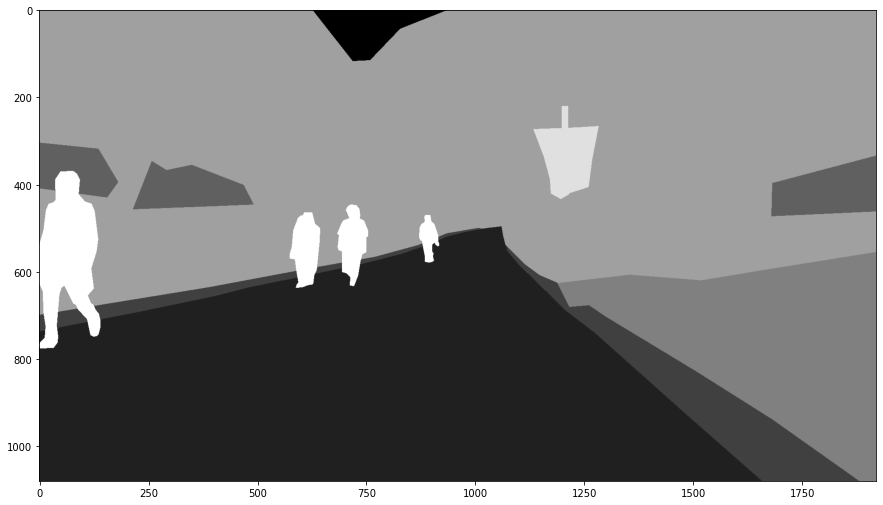

In [18]:
print("Gray Scale Values: ", np.unique(label_mask))
for val in np.unique(label_mask):
    print("\tvalue: {} --> {}".format(val, reverse_class_names[val]))

# 이미지 출력
plt.figure(figsize=(15, 20))
plt.imshow(label_mask, cmap='gray')
plt.show()